In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings("ignore")

## Cleaning the Raw CSV file

In [38]:
# read in raw CSV file, convert to dataframe for cleanup
df = pd.read_csv("fy2024-property-assessment-data_1_5_2024.csv")
df.columns

Index(['PID', 'CM_ID', 'GIS_ID', 'ST_NUM', 'ST_NAME', 'UNIT_NUM', 'CITY',
       'ZIP_CODE', 'BLDG_SEQ', 'NUM_BLDGS', 'LUC', 'LU', 'LU_DESC',
       'BLDG_TYPE', 'OWN_OCC', 'OWNER', 'MAIL_ADDRESSEE',
       'MAIL_STREET_ADDRESS', 'MAIL_CITY', 'MAIL_STATE', 'MAIL_ZIP_CODE',
       'RES_FLOOR', 'CD_FLOOR', 'RES_UNITS', 'COM_UNITS', 'RC_UNITS',
       'LAND_SF', 'GROSS_AREA', 'LIVING_AREA', 'LAND_VALUE', 'BLDG_VALUE',
       'SFYI_VALUE', 'TOTAL_VALUE', ' GROSS_TAX ', 'YR_BUILT', 'YR_REMODEL',
       'STRUCTURE_CLASS', 'ROOF_STRUCTURE', 'ROOF_COVER', 'INT_WALL',
       'EXT_FNISHED', 'INT_COND', 'EXT_COND', 'OVERALL_COND', 'BED_RMS',
       'FULL_BTH', 'HLF_BTH', 'KITCHENS', 'TT_RMS', 'BDRM_COND',
       'BTHRM_STYLE1', 'BTHRM_STYLE2', 'BTHRM_STYLE3', 'KITCHEN_TYPE',
       'KITCHEN_STYLE1', 'KITCHEN_STYLE2', 'KITCHEN_STYLE3', 'HEAT_TYPE',
       'HEAT_SYSTEM', 'AC_TYPE', 'FIREPLACES', 'ORIENTATION', 'NUM_PARKING',
       'PROP_VIEW', 'CORNER_UNIT'],
      dtype='object')

In [39]:
# dropping uneccessary columns (irrelevant to our objective)
df.drop(['CM_ID', 'GIS_ID', 'BLDG_SEQ', 'LUC', 'OWN_OCC', 'ORIENTATION', 'YR_BUILT','YR_REMODEL', 'PROP_VIEW','CORNER_UNIT', 'SFYI_VALUE'], axis=1, inplace=True)

In [40]:
# lowercasing all column headers
df.columns = df.columns.str.lower()

In [41]:
# renaming specific column names: p_id and gross_tax
df.rename(columns={'pid': 'p_id', ' gross_tax ':'gross_tax'}, inplace=True)

In [42]:
# lowercasing column values of strings
lowercase_columns = ['st_name', 'unit_num','city','mail_addressee','mail_street_address', 
                 'mail_city', 'mail_state','structure_class', 'roof_structure', 
                 'roof_cover', 'int_wall', 'ext_fnished', 'int_cond','ext_cond', 
                 'overall_cond','bdrm_cond', 'bthrm_style1', 'bthrm_style2', 
                 'bthrm_style3', 'kitchen_type', 'kitchen_style1', 'kitchen_style2', 
                 'kitchen_style3', 'heat_type', 'heat_system', 'ac_type']
df[lowercase_columns] = df[lowercase_columns].apply(lambda col: col.str.lower() if col.dtype == "object" else col)

In [43]:
# dropping NaN values of key columns (later used as not null values in SQL table)
df = df.dropna(subset=['p_id', 'st_num', 'st_name','city', 'zip_code',
                       'num_bldgs', 'lu', 'lu_desc', 'total_value'])

In [44]:
# turning columns into ints, replacing any NaN values to 0
columns_to_int = ['st_num','zip_code', 'mail_zip_code', 'land_sf','gross_area',
                    'living_area','land_value', 'bldg_value','total_value',
                    'gross_tax','bed_rms', 'full_bth','hlf_bth','kitchens', 
                    'tt_rms','fireplaces', 'num_parking']
for col in columns_to_int:
    df[col] = df[col].astype(str)  
    df[col] = df[col].str.replace('$', '', regex=False) 
    df[col] = df[col].str.replace(',', '', regex=False) 
    df[col] = df[col].str.strip() 
    df[col] = df[col].replace('-', np.nan)

df[columns_to_int] = df[columns_to_int].apply(pd.to_numeric, errors='coerce')
df[columns_to_int] = df[columns_to_int].fillna(0.0)
df[columns_to_int] = df[columns_to_int].astype(int)

In [45]:
# turning specific column values into float (later utilized by SQL database)
columns_to_float = ['res_floor', 'cd_floor', 'res_units', 'com_units', 'rc_units', 'gross_tax']

for col in columns_to_float:
    df[col] = df[col].astype(str)  
    df[col] = df[col].str.replace('$', '', regex=False) 
    df[col] = df[col].str.replace(',', '', regex=False) 
    df[col] = df[col].str.strip() 
    df[col] = df[col].replace('-', np.nan)

df[columns_to_float] = df[columns_to_float].apply(pd.to_numeric, errors='coerce')
df[columns_to_float] = df[columns_to_float].fillna(0.0)
df[columns_to_float] = df[columns_to_float].astype(float)

# Cleaned DataFrame

In [46]:
df

,p_id,st_num,st_name,unit_num,city,zip_code,num_bldgs,lu,lu_desc,bldg_type,...,bthrm_style3,kitchen_type,kitchen_style1,kitchen_style2,kitchen_style3,heat_type,heat_system,ac_type,fireplaces,num_parking
0,100001000,104,putnam st,NaN,east boston,2128,1,R3,THREE-FAM DWELLING,RE - Row End,...,s - semi-modern,3f - 3 full eat in kitchens,s - semi-modern,s - semi-modern,s - semi-modern,w - ht water/steam,NaN,n - none,0,3
1,100002000,197,lexington st,NaN,east boston,2128,1,R3,THREE-FAM DWELLING,RM - Row Middle,...,m - modern,3f - 3 full eat in kitchens,m - modern,m - modern,m - modern,f - forced hot air,NaN,c - central ac,0,0
2,100003000,199,lexington st,NaN,east boston,2128,1,R3,THREE-FAM DWELLING,RM - Row Middle,...,m - modern,3f - 3 full eat in kitchens,s - semi-modern,s - semi-modern,s - semi-modern,s - space heat,NaN,n - none,0,0
3,100004000,201,lexington st,NaN,east boston,2128,1,R3,THREE-FAM DWELLING,RM - Row Middle,...,s - semi-modern,3f - 3 full eat in kitchens,s - semi-modern,s - semi-modern,s - semi-modern,w - ht water/steam,NaN,n - none,0,0
4,100005000,203,lexington st,NaN,east boston,2128,1,R2,TWO-FAM DWELLING,RE - Row End,...,n - no remodeling,2f - 2 full eat in kitchens,n - no remodeling,n - no remodeling,NaN,w - ht water/steam,NaN,n - none,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182235,2205665002,14,lake st,2,brighton,2135,1,CD,RESIDENTIAL CONDO,FS - Free Standing,...,NaN,f - full eat in,s - semi-modern,NaN,NaN,w - ht water/steam,i - indiv. cntrl,n - none,1,1
182236,2205665004,12,lake st,1,brighton,2135,1,CD,RESIDENTIAL CONDO,FS - Free Standing,...,NaN,f - full eat in,s - semi-modern,NaN,NaN,w - ht water/steam,i - indiv. cntrl,n - none,1,1
182239,2205668000,4,lake st,NaN,brighton,2135,1,R3,THREE-FAM DWELLING,CV - Conventional,...,m - modern,2f - 2 full eat in kitchens,m - modern,m - modern,m - modern,w - ht water/steam,NaN,n - none,0,2
182240,2205669000,2193,commonwealth av,NaN,brighton,2135,1,C,STRIP CTR STORES,319 - STRIP RETAIL/ OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [47]:
df.columns

Index(['p_id', 'st_num', 'st_name', 'unit_num', 'city', 'zip_code',
       'num_bldgs', 'lu', 'lu_desc', 'bldg_type', 'owner', 'mail_addressee',
       'mail_street_address', 'mail_city', 'mail_state', 'mail_zip_code',
       'res_floor', 'cd_floor', 'res_units', 'com_units', 'rc_units',
       'land_sf', 'gross_area', 'living_area', 'land_value', 'bldg_value',
       'total_value', 'gross_tax', 'structure_class', 'roof_structure',
       'roof_cover', 'int_wall', 'ext_fnished', 'int_cond', 'ext_cond',
       'overall_cond', 'bed_rms', 'full_bth', 'hlf_bth', 'kitchens', 'tt_rms',
       'bdrm_cond', 'bthrm_style1', 'bthrm_style2', 'bthrm_style3',
       'kitchen_type', 'kitchen_style1', 'kitchen_style2', 'kitchen_style3',
       'heat_type', 'heat_system', 'ac_type', 'fireplaces', 'num_parking'],
      dtype='object')

In [15]:
# saving as a csv file!
#df.to_csv('cleaned_prop_data.csv', index=False)

### Summary Statistics of Living Area and Gross Tax by Neighborhood
Living area: Living area square footage of the property 

Gross tax: Tax bill amount based on total assessed value multipleid by the tax rate per thousand

These summary statistics calculate median values of living area, gross tax, and total rooms

In [12]:
# Organized by neighborhood of boston
city_medians = df.groupby('city').agg({
    'living_area': 'median',
    'gross_tax': 'median',
    'tt_rms': 'median'
}).reset_index()

# renaming columns
city_medians.columns = ['city', 'median_living_area', 'median_gross_tax', 'median_total_rooms']

# rounding values
city_medians = city_medians.round({
    'median_living_area': 2, 'median_gross_tax': 2, 'median_total_rooms': 2
})

# convert to float
pd.set_option('display.float_format', '{:.2f}'.format)

# Sort by median_living_area in descending order
city_medians = city_medians.sort_values(by='median_living_area', ascending=False)

city_medians

,city,median_living_area,median_gross_tax,median_total_rooms
13,readville,40826.00,172455.00,0.00
3,brookline,3510.50,13070.00,8.50
12,newton,2294.00,7410.00,12.00
7,dorchester,2123.00,6947.00,7.00
16,roxbury crossing,1949.00,7904.50,5.00
11,mattapan,1877.50,6181.50,8.00
15,roxbury,1760.00,5584.00,5.00
9,hyde park,1578.00,5847.00,7.00
18,west roxbury,1570.00,7353.50,7.00
14,roslindale,1559.00,6855.00,6.00


## Visualizations of Cleaned Property Data

### Box plot of gross tax per city

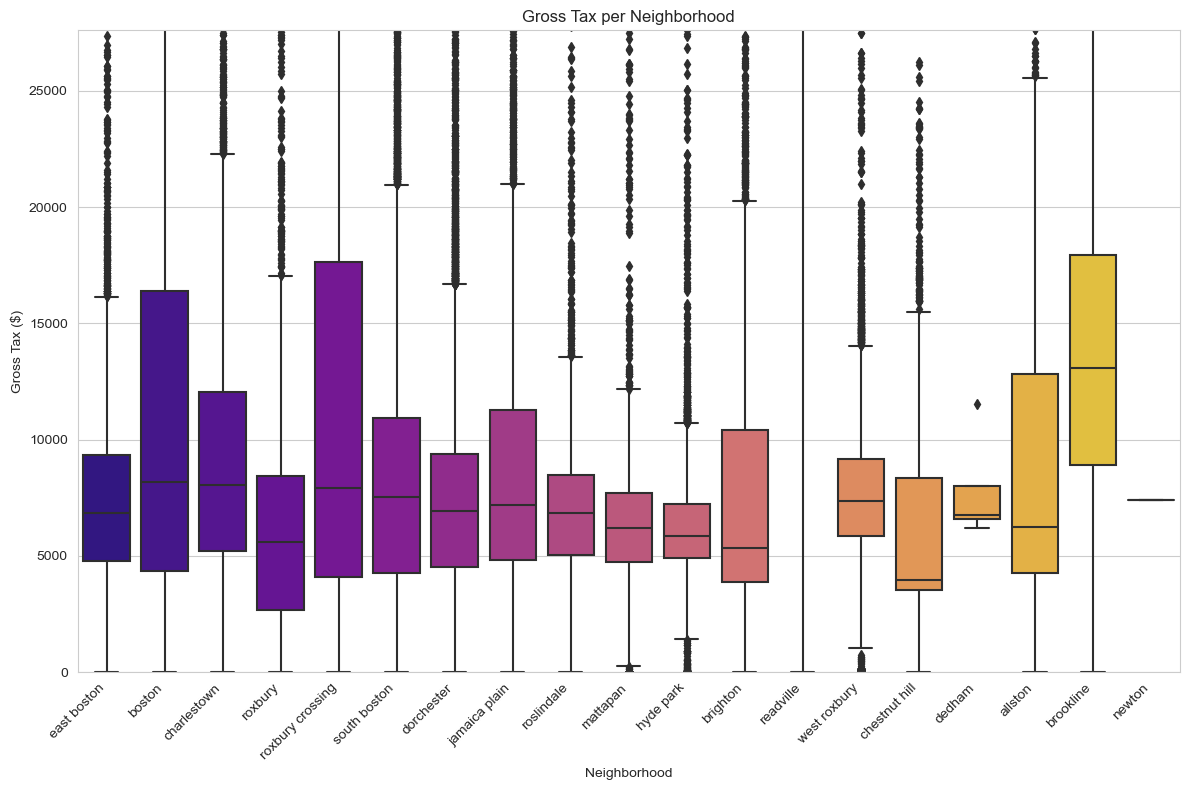

In [81]:
# Initializing figure
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.boxplot(x='city', y='gross_tax', data=df, palette='plasma')

# Taking values from the 95th percentile
plt.ylim(0, df['gross_tax'].quantile(0.95))
plt.title('Gross Tax per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Gross Tax ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Barplot of Median Living Area per City

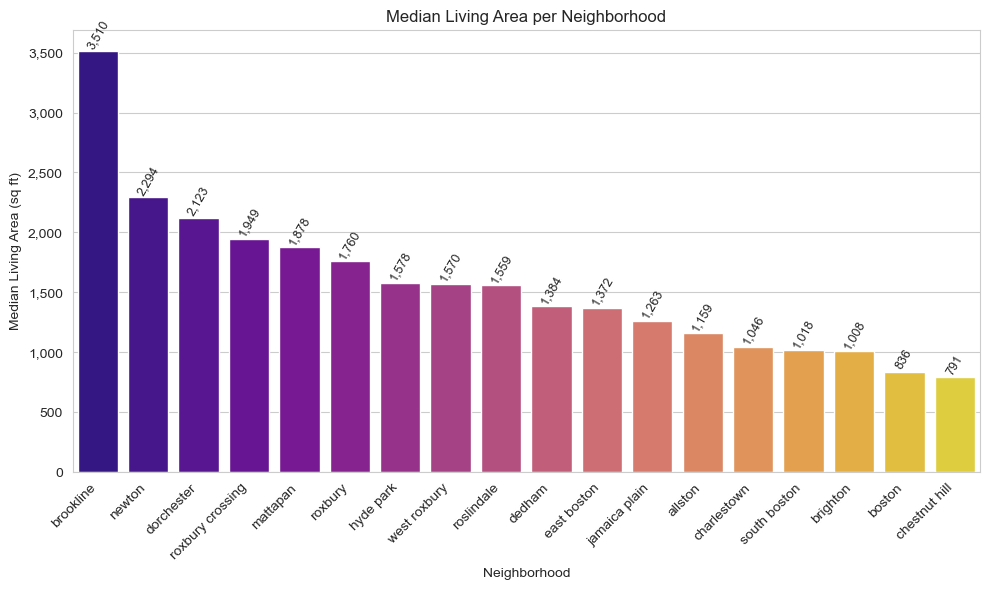

In [77]:
# Filtering out the city Readville because it contains only 2 values of data
city_median_living_area = city_medians.sort_values(by='median_living_area', ascending=False)
city_median_living_area = city_median_living_area[city_median_living_area['city'] != 'readville']

# Creating figure
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='city', y='median_living_area', data=city_median_living_area, palette='plasma')
plt.title('Median Living Area per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Median Living Area (sq ft)')
plt.xticks(rotation=45, ha='right')  

formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().yaxis.set_major_formatter(formatter)

# adding median value to each bar as an annotation
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:,.0f}', 
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', rotation=60, fontsize=9)

plt.tight_layout()
plt.show()

### Barplot of Total Value by City
Total value is the total assessed value for property

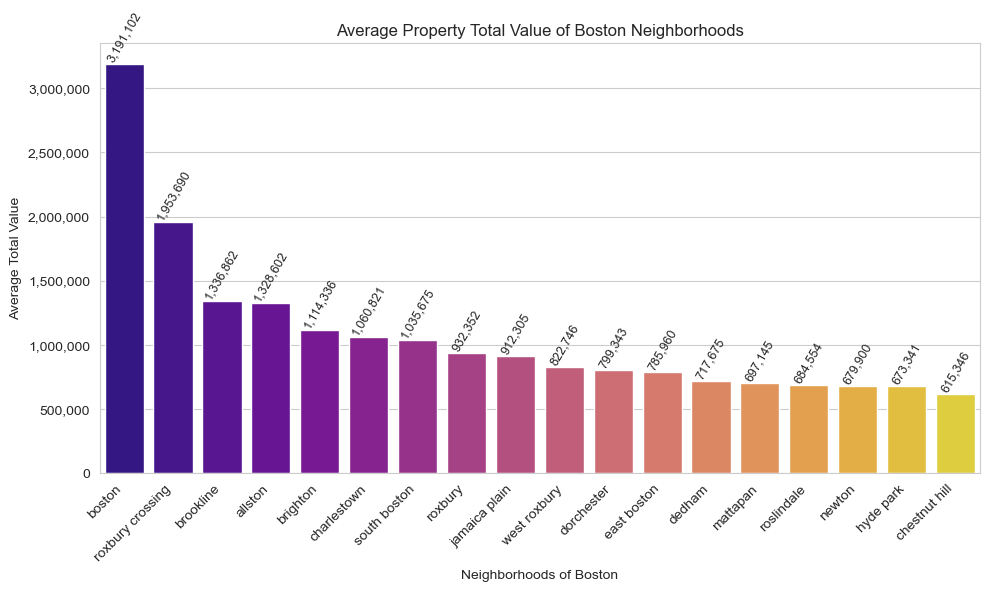

In [30]:
city_avg_total_value = df.groupby('city')['total_value'].mean().reset_index()
city_avg_total_value = city_avg_total_value.sort_values(by='total_value', ascending=False)
city_avg_total_value = city_avg_total_value[city_avg_total_value['city'] != 'readville']
plt.figure(figsize=(10, 6))

ax = sns.barplot(x='city', y='total_value', data=city_avg_total_value, palette='plasma')
plt.title('Average Property Total Value of Boston Neighborhoods')
plt.xlabel('Neighborhoods of Boston')
plt.ylabel('Average Total Value')
plt.xticks(rotation=45, ha='right') 

formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().yaxis.set_major_formatter(formatter)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:,.0f}', 
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', rotation=60, fontsize=9)

plt.tight_layout()

plt.show()

         int_cond       ext_cond    overall_cond  total_value
33  e - excellent       g - good   e - excellent   4037950.00
21  e - excellent    a - average   e - excellent   2755050.00
30  e - excellent  e - excellent  vg - very good   2574750.00
38  e - excellent       g - good  vg - very good   2396450.00
5     a - average  e - excellent   e - excellent   2341400.00
..            ...            ...             ...          ...
82       p - poor       p - poor     a - average    348900.00
83       p - poor       p - poor        f - fair    328700.00
41       f - fair    a - average        g - good    324850.00
75       p - poor    a - average        g - good    224100.00
42       f - fair  e - excellent     a - average     30100.00

[85 rows x 4 columns]


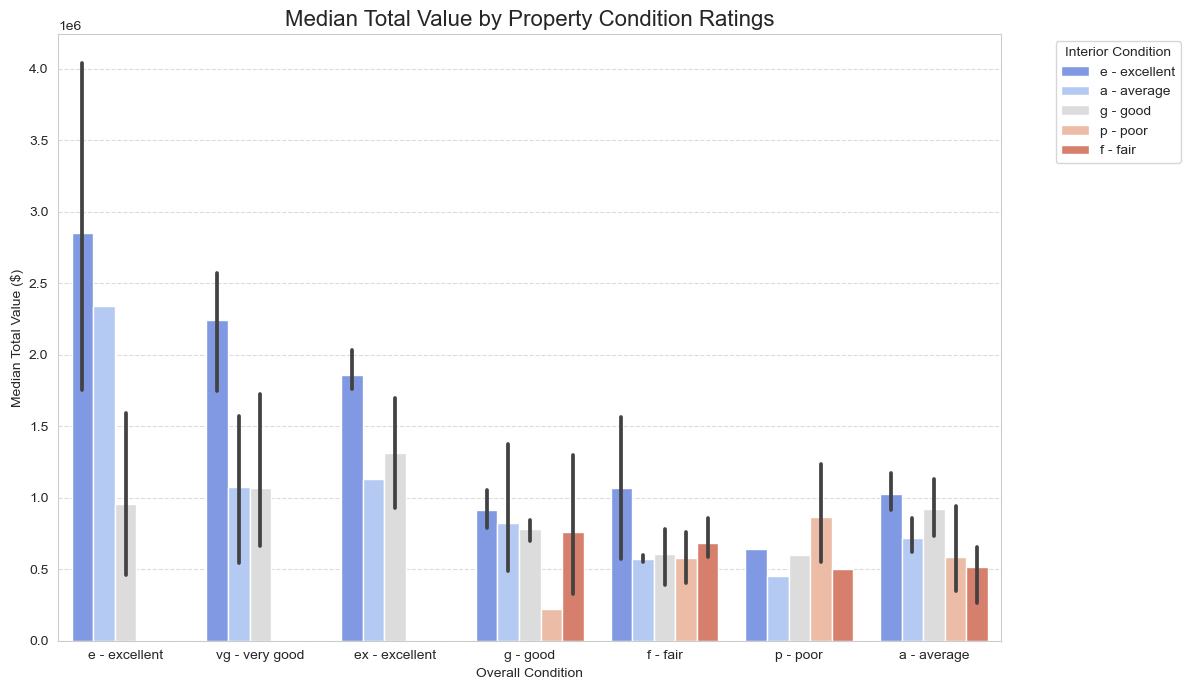

In [16]:
# Grouping by conditions and calculating the median total value
condition_analysis = df.groupby(['int_cond', 'ext_cond', 'overall_cond'])['total_value'].median().reset_index()

# Sorting for better visualization
condition_analysis = condition_analysis.sort_values(by='total_value', ascending=False)

# Display the grouped data
print(condition_analysis)
plt.figure(figsize=(12, 7))
sns.barplot(
    data=condition_analysis,
    x='overall_cond',
    y='total_value',
    hue='int_cond',
    palette='coolwarm'
)

plt.title("Median Total Value by Property Condition Ratings", fontsize=16)
plt.xlabel("Overall Condition")
plt.ylabel("Median Total Value ($)")
plt.legend(title="Interior Condition", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Bar plot displaying the ratio of Properties by Interor Condition type in each Neighborhood

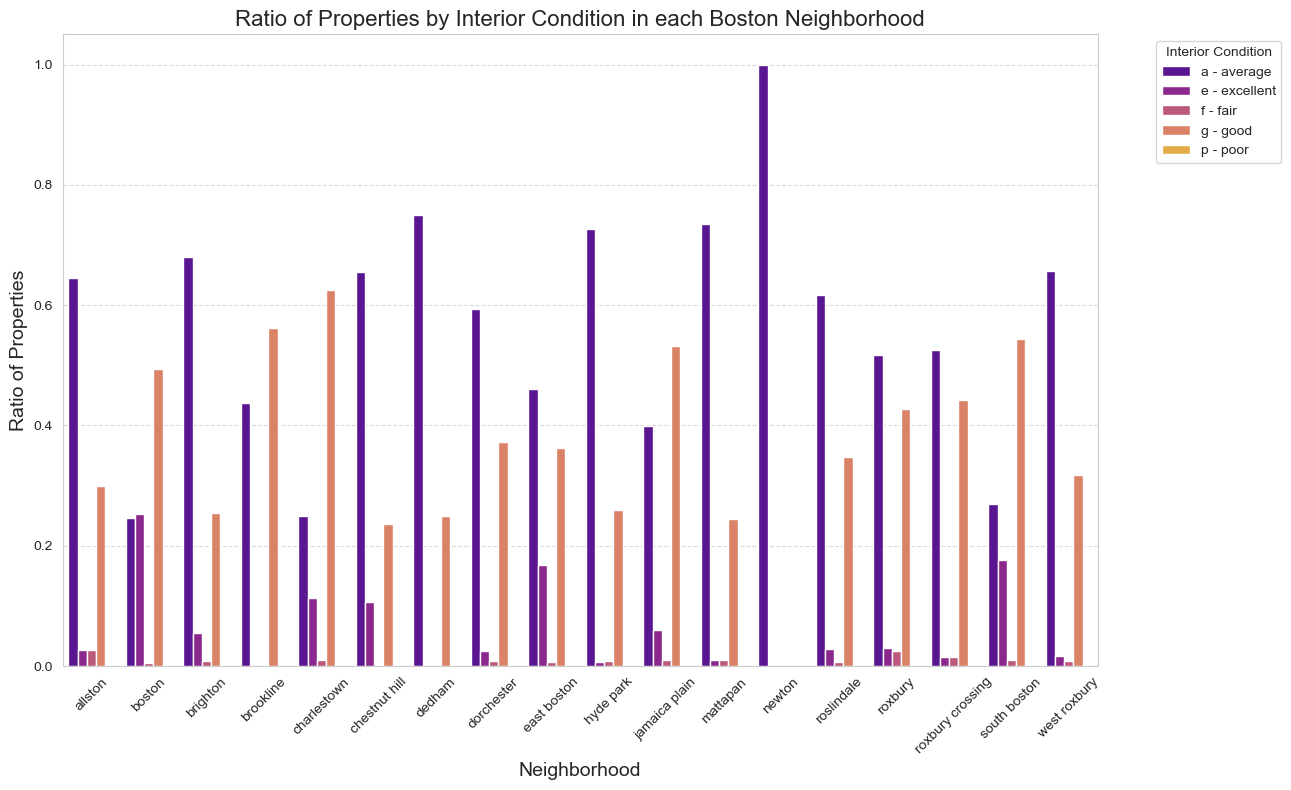

In [95]:
# groupby neighborhood and condition rating
condition_count = df.groupby(['city', 'int_cond']).size().reset_index(name='count')

# Find total number of properties per neighborhod
city_total = condition_count.groupby('city')['count'].transform('sum')

# Finding the ratio to show an accurate comparison 
condition_count['ratio'] = condition_count['count'] / city_total

# Initializing bar plot
plt.figure(figsize=(13, 8))
sns.barplot(
    data=condition_count,
    x='city',
    y='ratio',
    hue='int_cond',
    palette='plasma'
)

# Title, label and Legend
plt.title("Ratio of Properties by Interior Condition in each Boston Neighborhood", fontsize=16)
plt.xlabel("Neighborhood", fontsize=14)
plt.ylabel("Ratio of Properties", fontsize=14)
plt.legend(title="Interior Condition", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


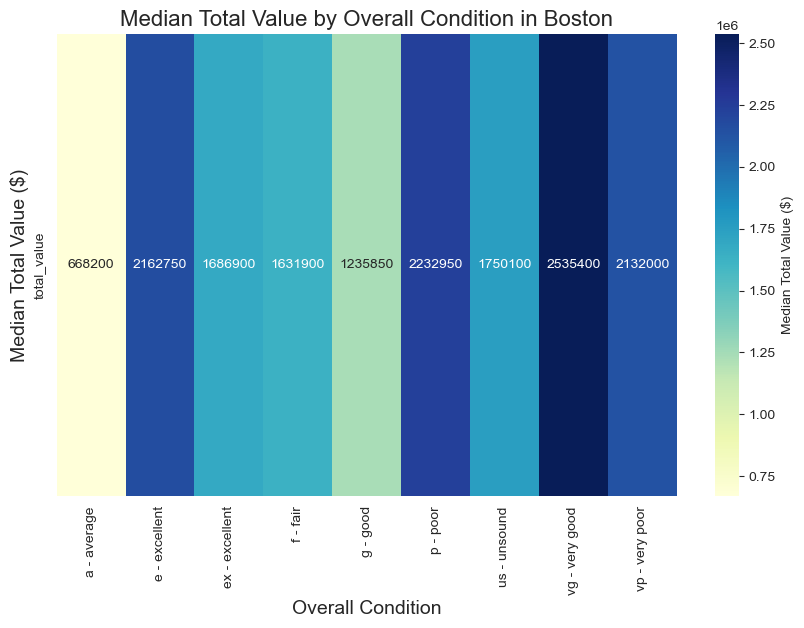

In [97]:
#Filtering the dataset for the city of Boston, this is applicable to any neighborhood by switching out the column
boston_data = df[df['city'] == 'boston']

# Finding the median total value for each overall condition listed in the neighborhood
heatmap_data = boston_data.groupby('overall_cond')['total_value'].median().reset_index()
heatmap_data.dropna(inplace=True)

# Initalize heatmap, titles and labels
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data[['overall_cond', 'total_value']].set_index('overall_cond').T,
    annot=True,
    fmt=".0f",
    cmap='YlGnBu',
    cbar_kws={'label': 'Median Total Value ($)'}
)
plt.title("Median Total Value by Overall Condition in Boston", fontsize=16)
plt.xlabel("Overall Condition", fontsize=14)
plt.ylabel("Median Total Value ($)", fontsize=14)
plt.show()


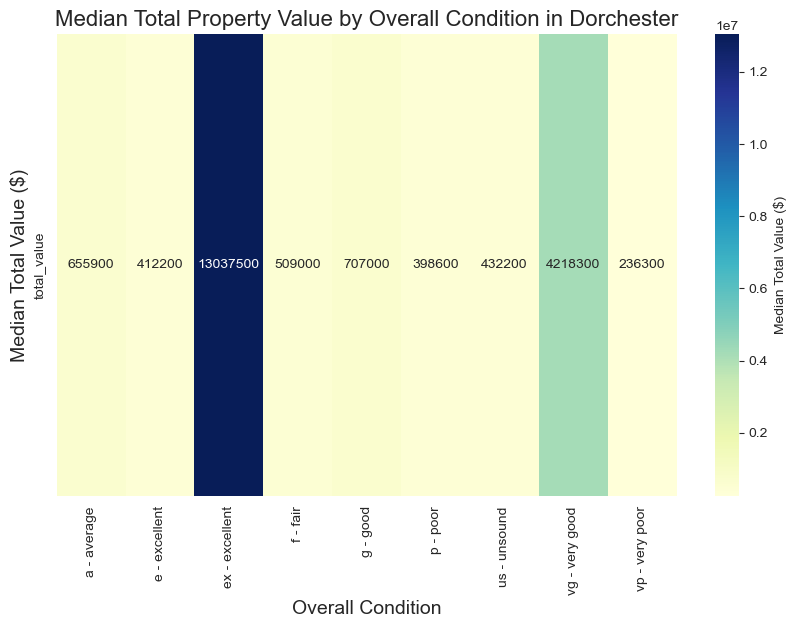

In [98]:
dorchester_data = df[df['city'] == 'dorchester']

# Finding the median total value for each overall condition listed in the neighborhood
heatmap_data = dorchester_data.groupby('overall_cond')['total_value'].median().reset_index()
heatmap_data.dropna(inplace=True)

# Initalize heatmap, titles and labels
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data[['overall_cond', 'total_value']].set_index('overall_cond').T,
    annot=True,
    fmt=".0f",
    cmap='YlGnBu',
    cbar_kws={'label': 'Median Total Value ($)'}
)
plt.title("Median Total Property Value by Overall Condition in Dorchester", fontsize=16)
plt.xlabel("Overall Condition", fontsize=14)
plt.ylabel("Median Total Value ($)", fontsize=14)
plt.show()

## Bar Plot of Number of Unique Property Types per Neighborhood

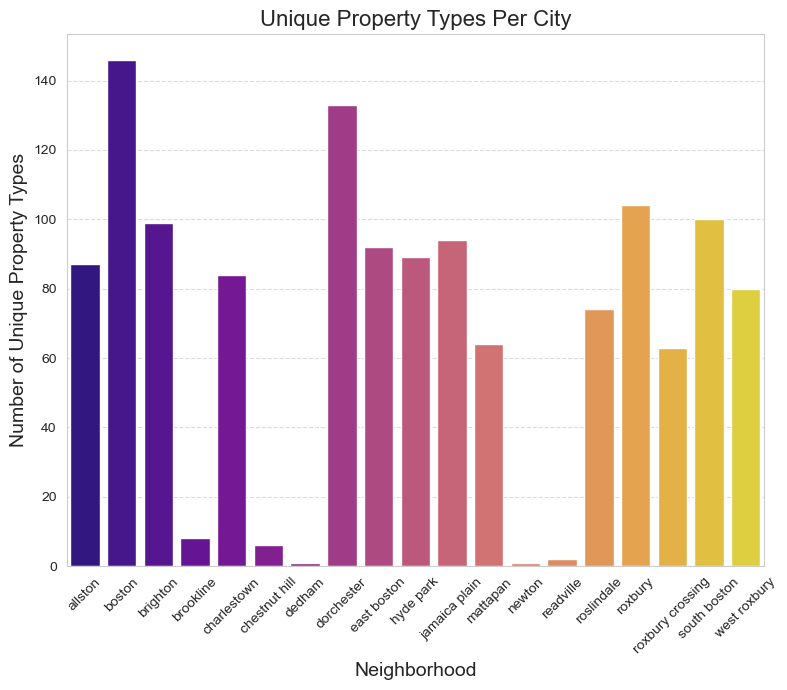

In [85]:
# Counting the amount of unique property types (known as lu_desc) in each neighborhood 
unique_lu_count = df.groupby('city')['lu_desc'].nunique().reset_index()
unique_lu_count.rename(columns={'lu_desc': 'unique_property_types'}, inplace=True)

# Initialize the bar plot
plt.figure(figsize=(8, 7))
sns.barplot(data=unique_lu_count, x='city', y='unique_property_types', palette='plasma')
plt.title('Unique Property Types Per City', fontsize=16)
plt.xlabel('Neighborhood', fontsize=14)
plt.ylabel('Number of Unique Property Types', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()